# Real or Not? NLP with Disaster Tweets

### Predict which Tweets are about real disasters and which ones are not

In [449]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import re

In [450]:
sample=pd.read_csv(r'C:\\Users\\Prabhat Singh\Desktop\dataset\kaggle7\sample_submission.csv')
train=pd.read_csv(r'C:\\Users\\Prabhat Singh\Desktop\dataset\kaggle7\train.csv')
test=pd.read_csv(r'C:\\Users\\Prabhat Singh\Desktop\dataset\kaggle7\test.csv')

In [451]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [452]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [453]:
print(f"shape of train: {train.shape}")
print(f"shape of test: {test.shape}")

shape of train: (7613, 5)
shape of test: (3263, 4)


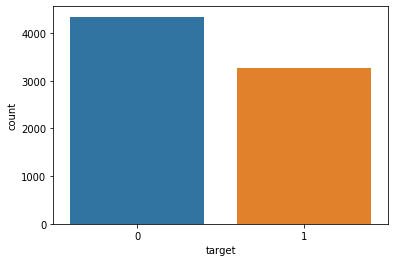

In [454]:
# Number of non disaster and disaster tweet
sns.countplot(train["target"])

In [455]:
# missing value in train 
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [456]:
# missing value in test
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [457]:
col =["id","text","target"]
train =train[col]

In [458]:
col1= ["id","text"]
test = test[col1]

In [459]:
print(f"shape of train: {train.shape}")
print(f"shape of test: {test.shape}")

shape of train: (7613, 3)
shape of test: (3263, 2)


In [460]:
disaster_tweet = train[train["target"] ==1]["text"]
non_disaster_tweet = train[train["target"] == 0]["text"]

In [461]:
# how disaster tweet looks
disaster_tweet.values[1]

'Forest fire near La Ronge Sask. Canada'

In [462]:
# how non disaster tweet looks
non_disaster_tweet.values[1]

'I love fruits'

In [463]:
# Preprocessing
def pre(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [464]:
train["text"] = train["text"].apply(lambda x: pre(x))
test["text"] = test["text"].apply(lambda x: pre(x))

In [465]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train["text"] =train["text"].apply(lambda x: tokenizer.tokenize(x))
test["text"] =test["text"].apply(lambda x: tokenizer.tokenize(x))

In [466]:
train.head()

,id,text,target
0,1,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[all, residents, asked, to, shelter, in, place...",1
3,6,"[people, receive, wildfires, evacuation, order...",1
4,7,"[just, got, sent, this, photo, from, ruby, ala...",1


In [467]:
# removing the stop words
def stp(text):
    words=[w for w in text if w not in stopwords.words("english")]
    return words
train["text"] = train["text"].apply(lambda x : stp(x))
test["text"] = test["text"].apply(lambda x : stp(x))

In [468]:
# lemmatize the word in text
import nltk
from nltk.stem import WordNetLemmatizer 
wnl=WordNetLemmatizer()
def lemma(text):
    text = [wnl.lemmatize(word) for word in text]
    return text
train["text"] = train["text"].apply(lambda x: lemma(x))
test["text"]= test["text"].apply(lambda x: lemma(x))

In [469]:
# combining all the data
def com(text):
    combined = " ".join(text)
    return combined
train["text"]= train["text"].apply(lambda x: com(x))
test["text"]= test["text"].apply(lambda x: com(x))

In [470]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
coun_vect = CountVectorizer()
train_vec = coun_vect.fit_transform(train["text"])
test_vec = coun_vect.transform(test["text"])

In [471]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [472]:
# building model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

In [473]:
# Logistic Regression Classifier
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vec, train["target"], cv=5, scoring="f1")
scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.61886792, 0.53525913, 0.58340181, 0.53521127, 0.70007831])

In [474]:
clf.fit(train_vec, train["target"])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [475]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.58645096, 0.50965961, 0.54725473, 0.48190279, 0.66840731])

#### count vectorizer perform better than tfidf

In [476]:
# Naives Bayes Classifier
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vec, train["target"], cv=5, scoring="f1")
scores

array([0.64633141, 0.61151079, 0.67889908, 0.64435798, 0.73369565])

In [477]:
clf_NB.fit(train_vec, train["target"])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [478]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57703631, 0.58523726, 0.62104363, 0.60203139, 0.74344718])

In [479]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Tfidf perform better on naive bayes

In [480]:
# XGBoost
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vec, train["target"], cv=5, scoring="f1")
scores

array([0.4994709 , 0.3826087 , 0.47914818, 0.38275499, 0.53211009])

In [481]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.50054645, 0.3870334 , 0.47670251, 0.38266385, 0.56759176])

In [494]:
# submitting a file
sample["target"] = clf_NB_TFIDF.predict(test_tfidf)
sample.to_csv("sample.csv",index=False)